In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import yfinance as yf
import random

In [2]:
class IterativeBase():
    def __init__(self, symbol, start, end, amount, use_spread = True):
        self.symbol=symbol
        self.start=start
        self.end=end
        self.initial_balance = amount
        self.current_balance = amount
        self.esunits = 0
        self.estrades = 0
        self.nqunits = 0
        self.nqtrades = 0
        self.ymunits = 0
        self.ymtrades = 0
        self.rtytrades = 0
        self.rtyunits = 0
        self.nqposition = 0
        self.ymposition = 0
        self.esposition = 0
        self.rtyposition = 0
        self.nq=1
        self.cumnav = []
        self.cumnavdf = []
        self.xmethod = []
        self.use_spread=use_spread
        self.firstfive = 0
        self.simdf = pd.DataFrame()
        self.get_data()
        
    def get_data(self):
        test= pd.read_csv("5mindataESYMNQ", parse_dates=[0], index_col=0).dropna()
#         test.index = pd.to_datetime(test.index, utc=True)
#         test = test.tz_convert('US/Eastern')
        test= test.loc[self.start:self.end]
        self.data = test
        
    def plot_data(self, cols = None):
        if cols is None:
            cols="ESClose"
        self.data[cols].plot(figsize = (12,8))
        
    def get_values(self, bar):
        date= str(self.data.index[bar])
        esclose= self.data["ESClose"].iloc[bar]
        nqclose= self.data["NQClose"].iloc[bar]
        ymclose= self.data["YMClose"].iloc[bar]
        rtyclose= self.data["RTYClose"].iloc[bar]
        return date, esclose, nqclose, ymclose, rtyclose
    
    
    def print_current_balance(self, bar):
        date, esclose, nqclose, ymclose, rtyclose = self.get_values(bar)
        print("{}| Current Balance: {}".format(date, round(self.current_balance, 2)))
        
    def buy_es(self, bar, esunits = None, amount = None):
        date, esclose, nqclose, ymclose, rtyclose = self.get_values(bar)
        if self.use_spread:
            esclose+= esclose*.0000652
        if amount is not None:
            esunits = int(amount / esclose)
        self.current_balance -= esunits * esclose
        self.esunits += esunits
        self.estrades += 1
        print("{}| Bot {} ES @ {}".format(date, esunits, esclose))
    
    def sell_es(self, bar, esunits = None, amount=None):
        date, esclose, nqclose, ymclose, rtyclose = self.get_values(bar)
        if self.use_spread:
            esclose-= esclose*.0000652
        if amount is not None:
            esunits = int(amount / esclose)
        self.current_balance += esunits * esclose
        self.esunits -= esunits
        self.estrades += 1
        print("{}| Sold {} ES @ {}".format(date, esunits, esclose))  
        
    def buy_nq(self, bar, nqunits = None, amount = None):
        date, esclose, nqclose, ymclose, rtyclose = self.get_values(bar)
        if self.use_spread:
            nqclose+= nqclose*.0000093
        if amount is not None:
            nqunits = int(amount / nqclose)
        self.current_balance -= nqunits * nqclose
        self.nqunits += nqunits
        self.nqtrades += 1
        print("{}| Bot {} NQ @ {}".format(date, nqunits, nqclose))
        
    def sell_nq(self, bar, nqunits = None, amount = None):
        date, esclose, nqclose, ymclose, rtyclose = self.get_values(bar)
        if self.use_spread:
            nqclose-= nqclose*.0000093 # ROUNDTRIP COMMISSION ONLY. ASSUMES lIMITS ORDERS. MARKET ORDERS ON YM
        if amount is not None:
            nqunits = int(amount / nqclose)
        self.current_balance += nqunits * nqclose
        self.nqunits -= nqunits
        self.nqtrades += 1
        print("{}| Sold {} NQ @ {}".format(date, nqunits, nqclose))
        
    def buy_ym(self, bar, ymunits = None, amount = None):
        date, esclose, nqclose, ymclose, rtyclose = self.get_values(bar)
        if self.use_spread:
            ymclose+= ymclose*.00012 #.00019 assumes 6 pt spread. ROUNDTRIP COMMISSION + FULL SPREAD.
        if amount is not None:
            ymunits = int(amount / ymclose)
        self.current_balance -= ymunits * ymclose
        self.ymunits += ymunits
        self.ymtrades += 1
        print("{}| Bot {} YM @ {}".format(date, ymunits, ymclose))
    
    def sell_ym(self, bar, ymunits = None, amount = None):
        date, esclose, nqclose, ymclose, rtyclose = self.get_values(bar)
        if self.use_spread:
            ymclose-= ymclose*.00012       
        if amount is not None:
            ymunits = int(amount / ymclose)
        self.current_balance += ymunits * ymclose
        self.ymunits -= ymunits
        self.ymtrades += 1
        print("{}| Sold {} YM @ {}".format(date, ymunits, ymclose))
    
    def buy_rty(self, bar, rtyunits = None):
        date, esclose, nqclose, ymclose, rtyclose = self.get_values(bar)
        self.current_balance -= rtyunits * rtyclose
        self.rtyunits += rtyunits
        self.rtytrades += 1
        print("{}| Bot ES @ {}".format(date, rtyclose))
    
    def sell_rty(self, bar, rtyunits = None):
        date, esclose, nqclose, ymclose, rtyclose = self.get_values(bar)
        self.current_balance += rtyunits * rtyclose
        self.rtyunits -= rtyunits
        self.rtytrades += 1
        print("{}| Sold RTY @ {}".format(date, rtyclose)) 
        
    def print_current_nav(self, bar):
        date, esclose, nqclose, ymclose, rtyclose = self.get_values(bar)
        nav = self.current_balance + (self.esunits * esclose)+ (self.rtyunits * rtyclose) + (self.nqunits * nqclose) + (self.ymunits * ymclose)
        self.cumnavdf.append([date, nav, esclose])
        self.cumnav.append(nav)
#         x=np.log(self.cumnav[-1]/self.cumnav[-2])
        print("{} | Net Asset Value = {}".format(date, round(nav,2)))
    
    def close_position(self, bar):
        date, esclose, nqclose, ymclose, rtyclose = self.get_values(bar)
        self.current_balance += self.esunits * esclose # closing final position (works with short and long!)
        self.current_balance += self.nqunits * nqclose
        self.current_balance += self.ymunits * ymclose
        self.current_balance += self.rtyunits * rtyclose
        self.esunits = 0 # setting position to neutral
        self.nqunits = 0
        self.ymunits = 0
        self.rtyunits = 0
        self.nqtrades += 1
        self.estrades += 1
        #self.ymtrades += 1
        #self.rtytrades += 1   
    def method(self, bar):
        date, esclose, nqclose, ymclose, rtyclose = self.get_values(bar)
        units=self.nqunits
        self.xmethod.append(units)
    
    def stats(self,bar):
        date, esclose, nqclose, ymclose, rtyclose = self.get_values(bar)
        simdf = pd.DataFrame(self.cumnavdf, columns=['Datetime', 'nav', 'NQ'])
        simdf['Datetime'] = pd.to_datetime(simdf['Datetime'])   
        simdf.set_index('Datetime',inplace=True)
        simdf["NQlogreturn"]=np.log(simdf["NQ"] / simdf["NQ"].shift(1))
        simdf["logret"]=np.log(simdf.nav/simdf.nav.shift(1))
        simdf["cumlogret"]=np.cumsum(simdf.logret).apply(np.exp)
        simdf["nqcumlogret"]=np.cumsum(simdf.NQlogreturn).apply(np.exp)
        simdf["cummax"]=simdf.cumlogret.cummax()
        simdf["drawdown"]=-(simdf["cumlogret"]-simdf["cummax"])/simdf["cummax"]
        logret=simdf["logret"]
        simdf["simpreturn"]=simdf.nav/simdf.nav.shift(1)-1
        self.simdf=simdf
        logretdown=np.where(logret<0,logret,0)
        downside_dev=np.sqrt(np.mean(logretdown**2))
        mean=simdf["logret"].mean()
        std=simdf["logret"].std()
        meansimp=simdf["simpreturn"].mean()
        annualmean=mean*252
        sortino=(mean-.00012)/downside_dev*np.sqrt(252)
        maxdrawdown=simdf.drawdown.max()
        skew=logret.skew()
        kurt=logret.kurt()
        years=(self.data.index[-1]-self.data.index[1]).days/365
        cagr=(self.cumnav[-1]/self.initial_balance)**(1/years)-1
        benchmarkcagr=(simdf["NQ"].iloc[-1] / simdf["NQ"].iloc[0])**(1/years)-1
        maxdayloss= simdf["simpreturn"].min()
        dd50=(simdf["drawdown"]>.5).mean()
        dd25=(simdf["drawdown"]>.25).mean()
        var=simdf["simpreturn"].var()
        kelly=meansimp/var
        print("Ave. log Return per trade = {}".format(round(mean, 5)))
        print("Ave. simple Return per trade = {}".format(round(meansimp, 5)))
        print("Std per trade = {}".format(std))
        print("Downside dev per trade = {}".format(downside_dev))
        print("CAGR = {}%".format(round(cagr*100, 1)))
        print("Benchmark CAGR = {}%".format(round(benchmarkcagr*100,1)))
        print("Max Drawdown = {}%".format(round(-maxdrawdown*100, 1)))
        print("Max Daily Loss = {}%".format(round(maxdayloss*100, 1)))
        print("% days down 50% from peak = {}%".format(round(dd50*100, 1)))
        print("% days down 25% from peak = {}%".format(round(dd25*100, 1)))
        print("Sortino = {}".format(round(sortino, 2)))
        print("Skew = {}".format(round(skew, 2)))
        print("Kurtosis = {}".format(round(kurt, 2)))
        print("Kelly Criterion = {}".format(round(kelly, 2)))
        plt.yscale("log") 
        plt.plot(simdf[["cumlogret","nqcumlogret"]])
        #simdf.loc["2007":"2022",["cumlogret","nqcumlogret"]].plot(figsize=[13,10], yscale="log")
        
        
       
    def close_pos(self, bar):
        date, esclose, nqclose, ymclose, rtyclose = self.get_values(bar)
        print(75 * "-")
        print("{} | +++ CLOSING FINAL POSITION +++".format(date))
        self.current_balance += self.esunits * esclose # closing final position (works with short and long!)
        self.current_balance += self.nqunits * nqclose
        self.current_balance += self.ymunits * ymclose
        self.current_balance += self.rtyunits * rtyclose
        print("{} | closing position of {} ES for {}".format(date, self.esunits, esclose))
        print("{} | closing position of {} NQ for {}".format(date, self.nqunits, nqclose))
        print("{} | closing position of {} YM for {}".format(date, self.ymunits, ymclose))
        print("{} | closing position of {} RTY for {}".format(date, self.rtyunits, rtyclose))
        self.esunits = 0 # setting position to neutral
        self.nqunits = 0
        self.ymunits = 0
        self.rtyunits = 0
        self.nqtrades += 1
        self.estrades += 1
        self.ymtrades += 1
        self.rtytrades += 1
        perf = (self.current_balance - self.initial_balance) / self.initial_balance * 100
        self.print_current_balance(bar)
        print("{} | net performance (%) = {}".format(date, round(perf, 2) ))
        print("{} | number of trades executed = {}".format(date, ((self.estrades+self.nqtrades+self.ymtrades+self.rtytrades)/2)))
        print("per trade: {}".format((self.current_balance - self.initial_balance) /((self.estrades+self.nqtrades+self.ymtrades+self.rtytrades)/2)))
        self.stats(bar)
        print(75 * "-")

In [3]:
class Momentum(IterativeBase):
    
    
    def ym_nq_momentum(self, period, dayperiod, zperiod, aperiod,bperiod,cperiod, entryhr, checkhr,checkhr2, exithr, x, y,z,a, lev,entryday,exitday):
        
        # nice printout
        stm = "Testing Intraday Momentum Strategy , periods:{}, entry:{}, checkhr:{}, exit:{}, leverage:{} ".format(period, entryhr, checkhr, exithr, lev)
        print("-" * 75)
        print(stm)
        print("-" * 75)
        
        # reset 
        self.esunits = 0
        self.estrades = 0
        self.nqunits = 0
        self.nqtrades = 0
        self.ymunits = 0
        self.ymtrades = 0
        self.nqposition = 0
        self.ymposition = 0
        self.esposition = 0
        
        self.current_balance = self.initial_balance  # reset initial capital
        self.get_data() # reset dataset
        self.firstfive = 0
        self.bestreturndow = pd.DataFrame()
        self.bestreturnnas = pd.DataFrame()
        self.dummynas=0
        self.dummydow=0
        self.besthourdow=0
        self.besthournas=0

        self.data["NQxperiodReturn"]=np.log(self.data["NQClose"]/self.data["NQClose"].shift(period))
        self.data["YMxperiodReturn"]=np.log(self.data["YMClose"]/self.data["YMClose"].shift(period))
        
        
        self.data["ESyperiodReturn"]=np.log(self.data["ESClose"]/self.data["ESClose"].shift(dayperiod))
        self.data["NQyperiodReturn"]=np.log(self.data["NQClose"]/self.data["NQClose"].shift(dayperiod))
        self.data["YMyperiodReturn"]=np.log(self.data["YMClose"]/self.data["YMClose"].shift(dayperiod))

        self.data["NQzperiodReturn"]=np.log(self.data["NQClose"]/self.data["NQClose"].shift(zperiod))
        self.data["YMzperiodReturn"]=np.log(self.data["YMClose"]/self.data["YMClose"].shift(zperiod)) 
        self.data["NQaperiodReturn"]=np.log(self.data["NQClose"]/self.data["NQClose"].shift(aperiod))
        self.data["YMaperiodReturn"]=np.log(self.data["YMClose"]/self.data["YMClose"].shift(aperiod)) 
#        
        self.data["NQret"]=np.log(self.data["NQClose"]/self.data["NQClose"].shift(1))
        self.data["YMret"]=np.log(self.data["YMClose"]/self.data["YMClose"].shift(1))
        self.data["ESret"]=np.log(self.data["ESClose"]/self.data["ESClose"].shift(1))
        self.data["NQVol"]=self.data.NQret.rolling(2000).std()
        self.data["YMvol"]=self.data.YMret.rolling(2000).std()
        self.data["ESvol"]=self.data.ESret.rolling(2000).std()
        self.data["YMmultiplier"]=self.data.NQVol/self.data.YMvol 
        self.data["ESmultiplier"]=self.data.NQVol/self.data.ESvol 
#     
        
        #add hour
        self.data["hour"]=self.data.index.hour
        self.data['day'] = self.data.index.weekday
        self.data["month"]=self.data.index.month
        self.data.dropna(inplace=True)
        
        for bar in range(len(self.data)-1):
        #Saves net asset value into self.cumnavdf once per day    
            if self.data["hour"].iloc[bar]==23 and self.data["hour"].iloc[bar-1]!=23:
                self.print_current_nav(bar)
           
        #Checks to see which contract outperforms the other during first five minutes after the bell. Creates dummy variable.
            if self.data["hour"].iloc[bar]==entryhr and self.data["hour"].iloc[bar-6]==entryhr and self.data["hour"].iloc[bar-7]!=entryhr:# or self.data["hour"].iloc[bar]==entryhr+1:
                 
                if self.data["NQzperiodReturn"].iloc[bar]-(self.data["YMzperiodReturn"].iloc[bar]*self.data["YMmultiplier"].iloc[bar])>z:# and self.data["NQxperiodReturn"].iloc[bar]-(self.data["YMxperiodReturn"].iloc[bar]*self.data["YMmultiplier"].iloc[bar])>z:# and 
                    self.firstfive=1
                        
                elif (self.data["YMzperiodReturn"].iloc[bar]*self.data["YMmultiplier"].iloc[bar])-self.data["NQzperiodReturn"].iloc[bar]>z:# and(self.data["YMxperiodReturn"].iloc[bar]*self.data["YMmultiplier"].iloc[bar])-self.data["NQxperiodReturn"].iloc[bar]>z :# and 
                    self.firstfive=2                 
                else:
                    self.firstfive=0
        #Closes open positions during "exithr"          
            if self.nqposition!=0:   
                if self.data["hour"].iloc[bar]==exithr and self.data["hour"].iloc[bar-5]==exithr and self.data["hour"].iloc[bar-6]!=exithr:
                        self.close_position(bar)
                        self.nqposition=0
                        self.ymposition=0
                        self.esposition=0
                         
              
        #Checks which contract has outperformed the other since yesterday's close, volatility adjusted. If one contract
        #has outperformed the other by "x" in the last "period" periods, and also outperformed during the first five mins 
        #of trading, that contract is bought and the other sold in a corresponding quantity, volatility adjusted.
            if self.data["hour"].iloc[bar]==entryhr and self.data["hour"].iloc[bar-6]==entryhr:
            
                    if self.nqposition==0:#      
                        
                            if self.data["NQxperiodReturn"].iloc[bar]-(self.data["YMxperiodReturn"].iloc[bar]*self.data["YMmultiplier"].iloc[bar])>x:# and self.data["NQxperiodReturn"].iloc[bar]-self.data["YMxperiodReturn"].iloc[bar]<.005 and self.data["NQxperiodReturn"].iloc[bar]>.02:#-self.data["YMaperiodReturn"].iloc[bar]>z:
                                        cb=self.current_balance
                                        self.sell_ym(bar, amount=cb*lev*self.data["YMmultiplier"].iloc[bar])
                                        self.ymposition=-1
                                        self.buy_nq(bar, amount=cb*lev)
                                        self.nqposition=1
                                        self.nq=1
                                         
                            elif (self.data["YMxperiodReturn"].iloc[bar]*self.data["YMmultiplier"].iloc[bar])-self.data["NQxperiodReturn"].iloc[bar]>x:
                              
                                        cb=self.current_balance
        
                                        self.buy_ym(bar, amount=cb*lev*self.data["YMmultiplier"].iloc[bar])
                                        self.ymposition=1
                                        self.sell_nq(bar, amount=cb*lev)
                                        self.nqposition=-1
                                        self.nq=-1
#       #Stop loss check at "checkhr"                             
            elif self.data["hour"].iloc[bar]==checkhr and self.data["hour"].iloc[bar-4]==checkhr:# and self.data["hour"].iloc[bar-7]!=checkhr:
                if self.nqposition==1:
                    if self.data["NQyperiodReturn"].iloc[bar]-(self.data["YMyperiodReturn"].iloc[bar]*self.data["YMmultiplier"].iloc[bar])<y:# and self.data["NQxperiodReturn"].iloc[bar]-self.data["YMxperiodReturn"].iloc[bar]<z:
                                self.close_position(bar)
                                self.nqposition=0
                                self.ymposition=0
                                self.esposition=0
                                 
                                print("stopped")
                         
                elif self.ymposition==1:
                    if (self.data["YMyperiodReturn"].iloc[bar]*self.data["YMmultiplier"].iloc[bar])-self.data["NQyperiodReturn"].iloc[bar]<y:# and self.data["YMxperiodReturn"].iloc[bar]-self.data["NQxperiodReturn"].iloc[bar]<z:
                            self.close_position(bar)
                            self.nqposition=0
                            self.ymposition=0
                            self.esposition=0

                            print("stopped")
         
                
        self.close_pos(bar+1)
        return self.data

In [4]:
trade=Momentum("all3", "2007-01-04", "2009-01-03", 100000, use_spread=True)

---------------------------------------------------------------------------
Testing Intraday Momentum Strategy , periods:180, entry:9, checkhr:11, exit:9, leverage:4 
---------------------------------------------------------------------------
2007-01-18 09:30:00| Bot 53 YM @ 9831.1796
2007-01-18 09:30:00| Sold 202 NQ @ 1971.9816604
2007-01-18 23:05:00 | Net Asset Value = 103270.78
2007-01-21 23:15:00 | Net Asset Value = 103785.78
2007-01-22 09:30:00| Sold 58 YM @ 9780.82616
2007-01-22 09:30:00| Bot 213 NQ @ 1945.0180885
2007-01-22 23:00:00 | Net Asset Value = 103674.59
2007-01-23 23:00:00 | Net Asset Value = 103242.84
2007-01-24 09:55:00| Bot 60 YM @ 9792.17492
2007-01-24 09:55:00| Sold 213 NQ @ 1932.232030075
stopped
2007-01-24 23:10:00 | Net Asset Value = 101406.77
2007-01-25 09:30:00| Bot 59 YM @ 9843.18104
2007-01-25 09:30:00| Sold 207 NQ @ 1951.9818464
2007-01-25 23:00:00 | Net Asset Value = 100174.58
2007-01-28 23:10:00 | Net Asset Value = 100850.58
2007-01-29 09:30:00| Bot 60 YM

2007-04-24 23:00:00 | Net Asset Value = 116092.53
2007-04-25 09:30:00| Bot 48 YM @ 10152.21812
2007-04-25 09:30:00| Sold 231 NQ @ 1991.9814744
2007-04-25 23:25:00 | Net Asset Value = 112718.78
2007-04-26 09:40:00| Bot 46 YM @ 10246.2294
2007-04-26 09:40:00| Sold 225 NQ @ 2016.48124655
2007-04-26 23:00:00 | Net Asset Value = 113090.5
2007-04-29 23:05:00 | Net Asset Value = 112835.5
2007-04-30 23:10:00 | Net Asset Value = 112835.5
2007-05-01 09:30:00| Bot 46 YM @ 10226.227
2007-05-01 09:30:00| Sold 225 NQ @ 1998.9814093
2007-05-01 23:00:00 | Net Asset Value = 114558.38
2007-05-02 09:30:00| Bot 47 YM @ 10287.23432
2007-05-02 09:30:00| Sold 230 NQ @ 2002.231379075
2007-05-02 23:05:00 | Net Asset Value = 114627.08
2007-05-03 23:30:00 | Net Asset Value = 114992.08
2007-05-06 23:30:00 | Net Asset Value = 114992.08
2007-05-07 09:30:00| Bot 45 YM @ 10415.24968
2007-05-07 09:30:00| Sold 227 NQ @ 2022.731188425
2007-05-07 23:00:00 | Net Asset Value = 116074.33
2007-05-08 09:35:00| Bot 46 YM @ 103

2007-08-14 23:00:00 | Net Asset Value = 119584.17
2007-08-15 23:00:00 | Net Asset Value = 119063.17
2007-08-16 09:40:00| Sold 40 YM @ 9808.8228
2007-08-16 09:40:00| Bot 242 NQ @ 1961.0182373
stopped
2007-08-16 23:00:00 | Net Asset Value = 117218.16
2007-08-17 09:30:00| Bot 39 YM @ 10138.21644
2007-08-17 09:30:00| Sold 236 NQ @ 1978.9815953
stopped
2007-08-19 23:00:00 | Net Asset Value = 115347.38
2007-08-20 23:00:00 | Net Asset Value = 115347.38
2007-08-21 23:00:00 | Net Asset Value = 115347.38
2007-08-22 09:30:00| Sold 38 YM @ 10181.77804
2007-08-22 09:30:00| Bot 227 NQ @ 2025.268834825
2007-08-22 23:00:00 | Net Asset Value = 114857.67
2007-08-23 09:30:00| Bot 37 YM @ 10284.23396
2007-08-23 09:30:00| Sold 225 NQ @ 2037.9810466
2007-08-23 23:00:00 | Net Asset Value = 115026.5
2007-08-24 09:30:00| Bot 38 YM @ 10223.22664
2007-08-24 09:30:00| Sold 229 NQ @ 2022.9811861
stopped
2007-08-26 23:10:00 | Net Asset Value = 114883.33
2007-08-27 09:35:00| Sold 37 YM @ 10339.75908
2007-08-27 09:35

2007-12-20 23:00:00 | Net Asset Value = 181420.97
2007-12-23 23:00:00 | Net Asset Value = 183804.97
2007-12-24 09:35:00| Bot 68 YM @ 10397.24752
2007-12-24 09:35:00| Sold 336 NQ @ 2183.229695775
stopped
2007-12-26 09:30:00| Bot 67 YM @ 10399.24776
2007-12-26 09:30:00| Sold 332 NQ @ 2186.9796609
stopped
2007-12-26 23:05:00 | Net Asset Value = 179227.96
2007-12-27 09:30:00| Sold 68 YM @ 10367.75572
2007-12-27 09:30:00| Bot 326 NQ @ 2197.0204321
2007-12-27 23:05:00 | Net Asset Value = 180380.69
2007-12-28 09:30:00| Bot 72 YM @ 10301.236
2007-12-28 09:30:00| Sold 328 NQ @ 2185.229677175
2007-12-30 23:00:00 | Net Asset Value = 178693.03
2008-01-02 09:30:00| Sold 74 YM @ 10118.7856
2008-01-02 09:30:00| Bot 330 NQ @ 2154.770039175
2008-01-02 23:25:00 | Net Asset Value = 179940.56
2008-01-03 09:30:00| Bot 75 YM @ 9928.19124
2008-01-03 09:30:00| Sold 337 NQ @ 2114.9803305
2008-01-03 23:00:00 | Net Asset Value = 176852.33
2008-01-04 09:30:00| Bot 73 YM @ 9804.17636
2008-01-04 09:30:00| Sold 343 

2008-04-01 23:05:00 | Net Asset Value = 216119.88
2008-04-02 09:50:00| Sold 91 YM @ 9378.8744
2008-04-02 09:50:00| Bot 456 NQ @ 1894.51761885
2008-04-02 23:00:00 | Net Asset Value = 216877.42
2008-04-03 23:00:00 | Net Asset Value = 216001.42
2008-04-04 09:30:00| Sold 87 YM @ 9385.87356
2008-04-04 09:30:00| Bot 454 NQ @ 1902.0176886
2008-04-06 23:00:00 | Net Asset Value = 217893.89
2008-04-07 23:00:00 | Net Asset Value = 217708.89
2008-04-08 09:45:00| Bot 89 YM @ 9335.12008
2008-04-08 09:45:00| Sold 460 NQ @ 1890.732416025
2008-04-08 23:00:00 | Net Asset Value = 221572.11
2008-04-09 09:35:00| Bot 91 YM @ 9392.12692
2008-04-09 09:35:00| Sold 467 NQ @ 1888.732434625
2008-04-09 23:00:00 | Net Asset Value = 222454.86
2008-04-10 09:30:00| Sold 94 YM @ 9348.878
2008-04-10 09:30:00| Bot 474 NQ @ 1881.267495625
2008-04-10 23:00:00 | Net Asset Value = 228167.1
2008-04-11 09:30:00| Sold 101 YM @ 9234.89168
2008-04-11 09:30:00| Bot 490 NQ @ 1874.767435175
2008-04-13 23:00:00 | Net Asset Value = 22

2008-07-21 23:00:00 | Net Asset Value = 328302.49
2008-07-22 09:30:00| Bot 148 YM @ 8173.98076
2008-07-22 09:30:00| Sold 729 NQ @ 1821.48306005
2008-07-22 23:10:00 | Net Asset Value = 334218.99
2008-07-23 09:35:00| Sold 147 YM @ 8338.9992
2008-07-23 09:35:00| Bot 724 NQ @ 1854.51724685
2008-07-23 23:00:00 | Net Asset Value = 352283.39
2008-07-24 09:30:00| Sold 152 YM @ 8357.99692
2008-07-24 09:30:00| Bot 746 NQ @ 1880.267486325
2008-07-24 23:00:00 | Net Asset Value = 361646.37
2008-07-25 09:30:00| Sold 164 YM @ 8147.02224
2008-07-25 09:30:00| Bot 790 NQ @ 1858.267281725
2008-07-27 23:00:00 | Net Asset Value = 385178.87
2008-07-28 09:30:00| Sold 178 YM @ 8094.0286
2008-07-28 09:30:00| Bot 822 NQ @ 1875.51744215
2008-07-28 23:00:00 | Net Asset Value = 390195.12
2008-07-29 09:40:00| Sold 190 YM @ 7932.04804
2008-07-29 09:40:00| Bot 847 NQ @ 1849.51720035
2008-07-29 23:00:00 | Net Asset Value = 369977.18
2008-07-30 09:30:00| Bot 167 YM @ 8251.99012
2008-07-30 09:30:00| Sold 767 NQ @ 1887.2

2008-10-26 23:00:00 | Net Asset Value = 619765.89
2008-10-27 09:50:00| Bot 323 YM @ 5101.61212
2008-10-27 09:50:00| Sold 2037 NQ @ 1213.48871445
2008-10-27 23:00:00 | Net Asset Value = 590253.19
2008-10-28 09:30:00| Bot 303 YM @ 5166.61992
2008-10-28 09:30:00| Sold 1959 NQ @ 1225.9885982
2008-10-28 23:00:00 | Net Asset Value = 615086.51
2008-10-29 09:30:00| Bot 273 YM @ 5807.69684
2008-10-29 09:30:00| Sold 1881 NQ @ 1305.9878542
2008-10-29 23:00:00 | Net Asset Value = 553580.43
2008-10-30 09:30:00| Bot 244 YM @ 5980.7176
2008-10-30 09:30:00| Sold 1694 NQ @ 1354.48740315
2008-10-30 23:00:00 | Net Asset Value = 558811.75
2008-10-31 09:30:00| Bot 247 YM @ 5919.71028
2008-10-31 09:30:00| Sold 1754 NQ @ 1337.737558925
2008-11-02 23:10:00 | Net Asset Value = 591194.99
2008-11-03 23:00:00 | Net Asset Value = 595108.49
2008-11-04 09:30:00| Bot 242 YM @ 6266.75192
2008-11-04 09:30:00| Sold 1724 NQ @ 1380.237163675
stopped
2008-11-04 23:00:00 | Net Asset Value = 583702.39
2008-11-05 09:30:00| Bo

,NQClose,YMClose,ESClose,RTYClose,NQxperiodReturn,YMxperiodReturn,ESyperiodReturn,NQyperiodReturn,YMyperiodReturn,NQzperiodReturn,...,YMret,ESret,NQVol,YMvol,ESvol,YMmultiplier,ESmultiplier,hour,day,month
0,,,,,,,,,,,,,,,,,,,,,
2007-01-18 08:40:00,1970.50,9831.0,1249.75,1249.75,-0.008842,0.002852,0.002002,-0.007332,0.002852,-0.000888,...,-0.000203,-0.000400,0.000620,0.000471,0.000478,1.316933,1.297454,8,3,1
2007-01-18 08:45:00,1971.75,9835.0,1250.50,1250.50,-0.007956,0.003463,0.002803,-0.006949,0.003463,0.000634,...,0.000407,0.000600,0.000620,0.000471,0.000478,1.316898,1.297199,8,3,1
2007-01-18 08:50:00,1973.25,9842.0,1250.50,1250.50,-0.007321,0.004481,0.002803,-0.005811,0.004685,0.000760,...,0.000711,0.000000,0.000620,0.000471,0.000478,1.316637,1.297711,8,3,1
2007-01-18 08:55:00,1974.00,9842.0,1250.75,1250.75,-0.008450,0.002747,0.003003,-0.006690,0.004787,0.000380,...,0.000000,0.000200,0.000620,0.000471,0.000478,1.316696,1.297650,8,3,1
2007-01-18 09:00:00,1974.25,9846.0,1251.25,1251.25,-0.007695,0.003663,0.002801,-0.006186,0.004887,0.000127,...,0.000406,0.000400,0.000620,0.000471,0.000478,1.316344,1.297301,9,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2009-01-02 15:50:00,1287.25,5818.0,686.50,686.50,0.042653,0.056572,0.063519,0.048751,0.063325,0.003112,...,0.001892,0.001458,0.001277,0.001890,0.001728,0.675906,0.739112,15,4,1
2009-01-02 15:55:00,1282.75,5778.0,682.25,682.25,0.039151,0.049128,0.054597,0.041382,0.055145,-0.003502,...,-0.006899,-0.006210,0.001280,0.001896,0.001734,0.674937,0.738109,15,4,1
2009-01-02 16:00:00,1281.25,5776.0,682.00,682.00,0.036765,0.048418,0.054617,0.040822,0.055347,-0.001170,...,-0.000346,-0.000367,0.001279,0.001894,0.001732,0.675073,0.738321,16,4,1


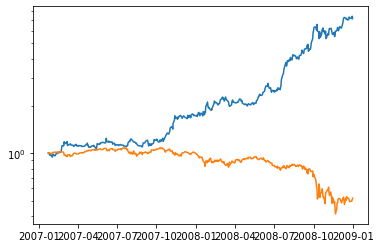

In [5]:
trade.ym_nq_momentum(180, 198, 1,276,186,233, 9, 11,14,9,.002, 0, 0,.002, 4,4,10) # period, dayperiod, zperiod, aperiod, entryhr, checkhr,checkhr2, exithr, x, y,z, a, lev)